<a href="https://colab.research.google.com/github/shumshersubashgautam/AI_TRAINING/blob/master/P24_CancerDetectionUsingKaggledatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd ..

/


In [2]:
cd root

/root


In [0]:
!mkdir .kaggle

In [4]:
cd .kaggle

/root/.kaggle


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shumshersubash2018","key":"3577298afccc49ea94c2161d1e3696d4"}'}

In [7]:
cd ..

/root


In [8]:
cd ..

/


In [9]:
cd content

/content


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:28<00:00, 128MB/s]
100% 3.10G/3.10G [00:28<00:00, 117MB/s]


In [0]:
!unzip -q breast-histopathology-images.zip

In [0]:
#rename /content/IDC_regular_ps50_idx5 to images

In [13]:
import numpy as np
import keras
from keras import backend as K
from keras.optimizers import Adam, SGD

from keras.layers import Flatten, Dropout, BatchNormalization, Reshape, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import pandas as pd

from keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.image as mpimg

import shutil
import os

Using TensorFlow backend.


In [0]:
images_folder = os.listdir("images")

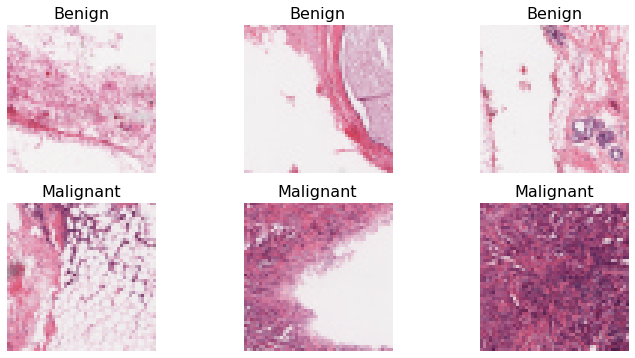

In [15]:
first_folder = images_folder[0]
benign_images_first_folder = f'images/{first_folder}/0'
benign_images = os.listdir(benign_images_first_folder)[0:3]
malignant_images_first_folder = f'images/{first_folder}/1'
malignant_images = os.listdir(malignant_images_first_folder)[0:3]

def plot_images(image_index, folder_name, image_name, title):
  sp = figure.add_subplot(2, 3, image_index + 1)
  sp.axis('Off')
  image_path = f'{folder_name}/{image_name}'
  image_loaded = img=mpimg.imread(image_path)
  sp.set_title(title, fontsize=16)
  plt.imshow(image_loaded, interpolation=None)

figure = plt.figure(figsize=(12, 6))

for image_index, image_name in enumerate(benign_images):
  plot_images(image_index, benign_images_first_folder, image_name, "Benign")

for image_index, image_name in enumerate(malignant_images):
  plot_images(image_index + 3, malignant_images_first_folder, image_name, "Malignant")

In [0]:
!mkdir training && mkdir validation

In [0]:
!mkdir training/benign && mkdir training/malignant

In [0]:
!mkdir validation/benign && mkdir validation/malignant

In [0]:
benign_images_training_folder_name = "training/benign"
malignant_images_training_folder_name = "training/malignant"

In [0]:
for folder in images_folder:
  benign_folder = os.listdir(f'images/{folder}/0')
  malignant_folder = os.listdir(f'images/{folder}/1')
  
  for benign_image in benign_folder:
    image_url = f'images/{folder}/0/{benign_image}'
    shutil.move(image_url, benign_images_training_folder_name)
    
  for malign_image in malignant_folder:
    image_url = f'images/{folder}/1/{malign_image}'
    shutil.move(image_url, malignant_images_training_folder_name)

In [0]:
benign_images = len(os.listdir(benign_images_training_folder_name))
malignant_images = len(os.listdir(malignant_images_training_folder_name))
total_images =  benign_images + malignant_images

In [22]:
print(f'Total images: {total_images}')
print(f'Benign images: {benign_images}')
print(f'Malignant images: {malignant_images}')

Total images: 277524
Benign images: 198738
Malignant images: 78786


In [0]:
validation_size = 0.20

benign_validation_folder_size = int(benign_images * 0.20)
malignant_validation_folder_size = int(malignant_images * 0.20)

In [24]:
print(f'Benign validation size: {benign_validation_folder_size}')
print(f'Malignant validation size: {malignant_validation_folder_size}')

Benign validation size: 39747
Malignant validation size: 15757


In [0]:
benign_images_validation_folder_name = "validation/benign"
malignant_images_validation_folder_name = "validation/malignant"

In [0]:
benign_images_training_folder = os.listdir(benign_images_training_folder_name)
malignant_images_training_folder = os.listdir(malignant_images_training_folder_name)

for image_name in benign_images_training_folder[:benign_validation_folder_size]:
  image_url = f'{benign_images_training_folder_name}/{image_name}'
  shutil.move(image_url, benign_images_validation_folder_name)
  
for image_name in malignant_images_training_folder[:malignant_validation_folder_size]:
  image_url = f'{malignant_images_training_folder_name}/{image_name}'
  shutil.move(image_url, malignant_images_validation_folder_name)

In [0]:
training_folder_size = len(os.listdir(benign_images_training_folder_name)) + len(os.listdir(malignant_images_training_folder_name))
validation_folder_size = len(os.listdir(benign_images_validation_folder_name)) + len(os.listdir(malignant_images_validation_folder_name))

In [28]:
print(f'Training folder size: {training_folder_size}')
print(f'Validation folder size: {validation_folder_size}')

Training folder size: 222020
Validation folder size: 55504


In [0]:
batch_size = 128
img_size = 48
input_img_size = (48, 48, 3)
num_classes = 2

In [30]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest").flow_from_directory(
    "training",
    target_size=(img_size, img_size),
    color_mode="rgb",
	  shuffle=True,
    batch_size=batch_size)

val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input).flow_from_directory(
    "validation",
    target_size=(img_size, img_size),
    color_mode="rgb",
	  shuffle=False,
    batch_size=batch_size)

Found 222020 images belonging to 2 classes.
Found 55504 images belonging to 2 classes.


In [0]:
train_steps = int(training_folder_size // batch_size)
val_steps = int(validation_folder_size // batch_size) 

In [32]:
train_steps, val_steps

(1734, 433)

In [0]:
def create_model():
  input_tensor = Input(shape=input_img_size)
  
  mobile_model = MobileNetV2(
       weights=None,
       input_tensor=input_tensor,
       input_shape=input_img_size,
       alpha=1.5,
       include_top=False)
  
  for layer in mobile_model.layers:
    layer.trainable = True
  
  mobile_model_output = mobile_model.output
  classification_layer = Flatten()(mobile_model_output)
  classification_layer = Dense(256, activation='relu')(classification_layer)
  classification_layer = Dropout(0.5)(classification_layer)
  predictions = Dense(activation="softmax", units=num_classes)(classification_layer)

  model = Model(inputs=input_tensor, outputs=predictions)
  
  return model

In [0]:
learning_rate = 3e-4
epochs = 2

In [0]:
def polynomial_decay(epoch):
	power = 1.0
 
	alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
	return alpha

In [0]:
y_true = np.concatenate((val_generator.classes, train_generator.classes))

In [0]:
cw = compute_class_weight('balanced', np.unique(y_true), y_true)

In [0]:
class_weights = {index: weight for index, weight in enumerate(cw)}

In [39]:
class_weights

{0: 0.6982157413277783, 1: 1.761251999086132}

In [0]:
weights_name = "epoch={epoch:02d}|accuracy={val_acc:.4f}.h5"

checkpoint = ModelCheckpoint(weights_name, monitor="val_acc", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="max", period=1)

lr_decay = LearningRateScheduler(polynomial_decay)

optimizer = SGD(lr=learning_rate, momentum=0.9)

In [41]:
model = create_model()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [42]:
trained_model = model.fit_generator(train_generator,
                        epochs=epochs,
                        class_weight=class_weights,
                        steps_per_epoch=train_steps,
                        callbacks=[checkpoint, lr_decay],
                        validation_data=val_generator,
                        validation_steps=val_steps,
                        verbose=1)



Epoch 1/2
1734/1734 [==============================] - 436s 252ms/step - loss: 0.4522 - acc: 0.8027 - val_loss: 0.5046 - val_acc: 0.7777

Epoch 00001: val_acc improved from -inf to 0.77773, saving model to epoch=01|accuracy=0.7777.h5
Epoch 2/2
1734/1734 [==============================] - 424s 245ms/step - loss: 0.3965 - acc: 0.8284 - val_loss: 0.3699 - val_acc: 0.8439

Epoch 00002: val_acc improved from 0.77773 to 0.84387, saving model to epoch=02|accuracy=0.8439.h5


In [0]:
def plot_validation_training(metric, trained_model):
  validation_metric = trained_model.history[f'val_{metric}']
  training_metric = trained_model.history[metric]
  epochs = range(len(training_metric))
  plt.plot(epochs, training_metric, 'b', label=f'Training {metric}')
  plt.plot(epochs, validation_metric, 'r', label=f'Validation {metric}')
  plt.ylim(bottom=0)
  plt.xlabel('Epochs ', fontsize=16)
  plt.ylabel(metric, fontsize=16)
  loc = 'upper right' if metric == "loss" else 'lower right'
  plt.legend(loc=loc)
  plt.title(f'Training and validation {metric}', fontsize = 20)
  plt.show()

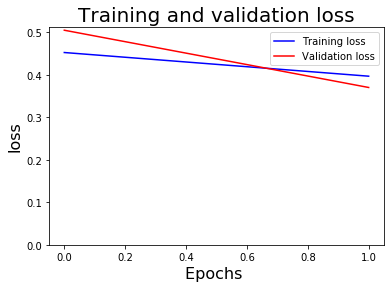

In [44]:
plot_validation_training("loss", trained_model)

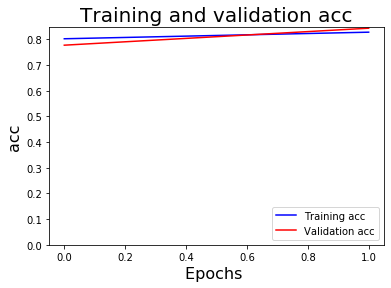

In [45]:
plot_validation_training("acc", trained_model)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
model.load_weights('/content/epoch=01|accuracy=0.7777.h5')

In [0]:
val_generator.reset()

In [49]:
classes_predicted = model.predict_generator(val_generator, steps=val_steps, verbose=1)

433/433 [==============================] - 33s 76ms/step


In [50]:
len(classes_predicted)

55424

In [0]:
real_classes = np.argmax(classes_predicted, axis=1)

In [0]:
val_labels = val_generator.classes

In [53]:
len(val_labels)

55504

In [0]:
val_labels = val_labels[:55424]

In [55]:
len(val_labels), len(real_classes)

(55424, 55424)

In [56]:
val_generator.class_indices

{'benign': 0, 'malignant': 1}

In [0]:
classes_names = ["Benign", "Malignant"]

Confusion matrix, without normalization


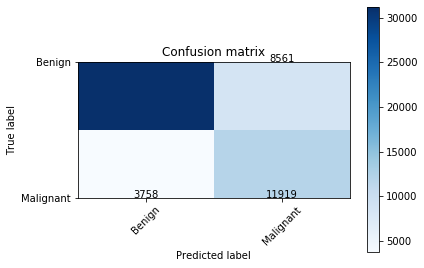

In [58]:
cm = confusion_matrix(val_labels, real_classes, labels=range(num_classes))
plot_confusion_matrix(cm, classes_names)

In [59]:
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print(f'sensitivity: {sensitivity}')

specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print(f'specifity: {specificity}')

sensitivity: 0.7846126751704531
specifity: 0.7602857689608982


In [0]:
from sklearn.metrics import classification_report

In [61]:
report = classification_report(val_labels, real_classes, target_names=classes_names)
print(report)

              precision    recall  f1-score   support

      Benign       0.89      0.78      0.84     39747
   Malignant       0.58      0.76      0.66     15677

    accuracy                           0.78     55424
   macro avg       0.74      0.77      0.75     55424
weighted avg       0.80      0.78      0.79     55424



In [0]:
model_json = model.to_json()
with open("breast_cancer_model.json", "w") as json_file:
    json_file.write(model_json)
